In [1]:
%reload_ext autoreload
%autoreload 2

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>Reference:</h3>
    <a href="https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8">https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8</a>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>Dataset</h3>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> YooChoose Dataset:</h4>
<a href = "https://2015.recsyschallenge.com/challenge.html">https://2015.recsyschallenge.com/challenge.html</a><br>
Given a sequence of click events performed by some user during a typical session in an e-commerce website, the goal is to predict whether the user is going to buy something or not, and if he is buying, what would be the items he is going to buy. The task could therefore be divided into two sub goals:
<ol>
<li>Is the user going to buy items in this session? Yes|No
<li>If yes, what are the items that are going to be bought?
</ol>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>In this tutorial, we will only be covering Task 1!</b>
</div>

<div style="background-color:rgba(192,192,192,0.3); padding:10px 0; font-size:110%; color:black;">
Pytorch Geometric provides a <b>Dataset</b> interface class that can be inherited to construct the dataset object.<br>
The following <b>Dataset</b> interface class methods must to be implemented:
<ul>
    <li><b>raw_file_names</b></li>
    The name of the files to find in the :obj:`self.raw_dir` folder in
        order to skip the download.
    <li><b>processed_file_names</b></li>
    The name of the files to find in the :obj:`self.processed_dir`
        folder in order to skip the processing.
    <li><b>download</b></li>
    Downloads the dataset to the :obj:`self.raw_dir` folder.
    <li><b>process</b></li>
    Processes the dataset to the :obj:`self.processed_dir` folder.
</ul>
</div>

In [3]:
from torch_geometric import utils, data
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import torch

In [4]:
import os
import numpy as np
from loguru import logger

In [5]:
target_dir = os.path.join(os.getcwd(), "tmp")

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>Preprocessing</h3>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Load data</b>
</div>

In [6]:
session_df = pd.read_csv(os.path.join(target_dir,"dataset/yoochoose-clicks.dat"))
session_df.columns = ["session_id", "timestamp", "item_id", "category"]

/home/pranjal/miniconda3/envs/gcn/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
session_df.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:54:09.868Z,214536500,0
1,1,2014-04-07T10:54:46.998Z,214536506,0
2,1,2014-04-07T10:57:00.306Z,214577561,0
3,2,2014-04-07T13:56:37.614Z,214662742,0
4,2,2014-04-07T13:57:19.373Z,214662742,0


In [8]:
#items interacted with during sessions
tmp_session_df = session_df[:20].copy()
tmp_session_df.groupby("session_id").agg({"item_id":list,"category":list})

,item_id,category
session_id,,
1,"[214536500, 214536506, 214577561]","[0, 0, 0]"
2,"[214662742, 214662742, 214825110, 214757390, 2...","[0, 0, 0, 0, 0, 0]"
3,"[214716935, 214774687, 214832672]","[0, 0, 0]"
4,"[214836765, 214706482]","[0, 0]"
6,"[214701242, 214826623]","[0, 0]"
7,"[214826835, 214826715]","[0, 0]"
8,"[214838855, 214838855]","[0, 0]"


<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Remove sessions with less than 2 items</b>
</div>

In [9]:
session_df["valid_session"] = session_df.session_id.map(
        session_df.groupby("session_id")["item_id"].size() > 2
    )
session_df = session_df.loc[session_df.valid_session].drop("valid_session", axis=1)

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Sample sessions for demo</b>
</div>

In [10]:
sample_sessions = 25000
if sample_sessions:
    logger.info(f"Sampling {sample_sessions} sessions...")
    sampled_session_id = np.random.choice(
        session_df.session_id.unique(), sample_sessions, replace=False
    )
    session_df = session_df.loc[session_df.session_id.isin(sampled_session_id)].copy()

2020-09-21 15:26:24.806 | INFO     | __main__:<module>:3 - Sampling 25000 sessions...


In [12]:
session_df.shape

(138910, 4)

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Map Item Ids</b><br>
<b>item_ids</b> are categorically encoded to ensure the encoded item_ids, which will later be mapped to an embedding matrix, starts at 0.
</div>

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
# map the item ids to a small range
logger.info("Mapping item ids to smaller range...")
item_encoder = LabelEncoder()
session_df["item_id"] = item_encoder.fit_transform(session_df.item_id)

2020-09-21 16:58:05.420 | INFO     | __main__:<module>:2 - Mapping item ids to smaller range...


<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Determine whether the sessions have buy event</b><br>
</div>

In [16]:
buy_df_path = os.path.join(target_dir,"dataset/yoochoose-buys.dat")

In [17]:
# get the target class (buy or not buy event) for the sessions
logger.info("Determining the target class of the sessions (buy/not buy)...")
buy_df = pd.read_csv(buy_df_path, header=None)
buy_df.columns = ["session_id", "timestamp", "item_id", "price", "quantity"]
session_df["label"] = session_df.session_id.isin(buy_df.session_id)
num_embeddings = session_df.item_id.max() + 1
del buy_df
logger.info("Loading dataset done!")

2020-09-21 16:59:16.570 | INFO     | __main__:<module>:2 - Determining the target class of the sessions (buy/not buy)...
2020-09-21 16:59:18.447 | INFO     | __main__:<module>:8 - Loading dataset done!


In [20]:
session_df.groupby("label").agg({"item_id":len})

,item_id
label,
False,121035
True,17875


<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<b>Make Graphs</b><br>
    The data is ready to be transformed into a Dataset object after the preprocessing step. Here, we treat each item in a session as a node, and therefore all items in the same session form a graph. To build the dataset, we group the preprocessed data by session_id and iterate over these groups. In each iteration, the item_id in each group are categorically encoded again since for each graph, the node index should count from 0.
</div>

In [26]:
from torch_geometric.data import InMemoryDataset, Data
from tqdm import tqdm

In [29]:
data_list = []
processed_path = os.path.join(target_dir, "yoochoose_click_binary_1M_sess_nb.dataset")

logger.info("Processing dataset...")
grouped = session_df.groupby("session_id")
for session_id, group in tqdm(grouped):
    #encode the item_ids for forming the edge_index
    sess_item_id = LabelEncoder().fit_transform(group.item_id)
    group = group.reset_index(drop=True)
    group["sess_item_id"] = sess_item_id
    node_features = (
        group.loc[group.session_id == session_id, ["sess_item_id", "item_id"]]
        .sort_values("sess_item_id")
        .item_id.drop_duplicates()
        .values
    )

    node_features = torch.LongTensor(node_features).unsqueeze(1)
    target_nodes = group.sess_item_id.values[1:]
    source_nodes = group.sess_item_id.values[:-1]

    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    x = node_features
    # the session id is same for all rows in a session (whether buy event or not)
    y = torch.FloatTensor([group.label.values[0]])

    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)
logger.info("Completed processing!")
data, slices = InMemoryDataset.collate(data_list)
torch.save((data, slices, num_embeddings), processed_path)
logger.info(f"Processed files saved as {processed_path}")

2020-09-21 17:21:16.533 | INFO     | __main__:<module>:4 - Processing dataset...
100%|██████████| 25000/25000 [02:10<00:00, 192.22it/s]
2020-09-21 17:23:27.072 | INFO     | __main__:<module>:29 - Completed processing!
2020-09-21 17:23:27.620 | INFO     | __main__:<module>:32 - Processed files saved as /home/pranjal/GCN/pytorch-gcn/tmp/yoochoose_click_binary_1M_sess_nb.dataset


In [31]:
del data
del slices

In [32]:
del session_df

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>All the above steps have been implemented in the following custom DataLoader class</h3>
</div>

In [33]:
from gcn.dataloader import YooChooseDataset

In [34]:
ds = YooChooseDataset(root=target_dir)

2020-09-21 18:13:51.501 | INFO     | gcn.dataloader:raw_file_names:32 - Required files check!


<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>Sample Graphs</h3>
</div>

In [38]:
session_num = 12

In [43]:
g_sample = utils.to_networkx(ds[session_num])

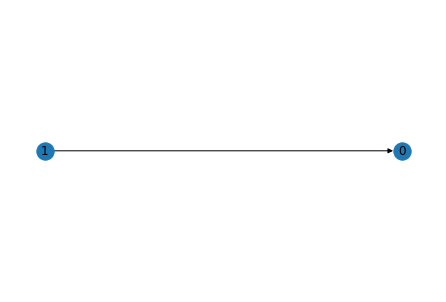

In [40]:
nx.draw_kamada_kawai(g_sample,with_labels=True)

In [46]:
ds[session_num].x

tensor([[20112],
        [20140]])

In [47]:
ds[session_num].edge_index

tensor([[1, 1, 1, 0],
        [1, 1, 0, 0]])

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h3>Model</h3>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
 <p>The following custom GNN takes reference from one of the examples in <a href="https://github.com/rusty1s/pytorch_geometric/blob/master/examples/proteins_topk_pool.py">PyG’s official Github repository</a>. The <a href="https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8"> author </a> has modified the output layer to match with a binary classification setup.</p>
</div>

```python
import torch
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from .sage_conv import SAGEConv


class Net(torch.nn.Module):
    def __init__(self, item_id_max, embed_dim):
        super(Net, self).__init__()
        self.embed_dim = embed_dim
        self.item_id_max = item_id_max
        self.conv1 = SAGEConv(self.embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(
            num_embeddings=self.item_id_max + 1, embedding_dim=self.embed_dim
        )
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)

        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))

        x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

```

In [30]:
#load model

In [21]:
#train:
# copy the code from main.py to here and complete

In [10]:
# dl = data.DataLoader(ds)

In [11]:
# item_embedding = torch.nn.Embedding(num_embeddings=ds.num_embeddings, embedding_dim=128)
# conv1 = SAGEConv(ds.num_embeddings, 128)

In [12]:
# for tr in dl:
#     x, edge_index, batch = tr.x, tr.edge_index, tr.batch
#     x = item_embedding(x)
#     x = x.squeeze(1)
#     y = conv1(x, edge_index)
#     break

In [49]:
from pathlib import Path

In [60]:
p = Path("ram/shyam/gopal/")

In [62]:
list(p.resolve().parents)

[PosixPath('/home/pranjal/GCN/pytorch-gcn/ram/shyam'),
 PosixPath('/home/pranjal/GCN/pytorch-gcn/ram'),
 PosixPath('/home/pranjal/GCN/pytorch-gcn'),
 PosixPath('/home/pranjal/GCN'),
 PosixPath('/home/pranjal'),
 PosixPath('/home'),
 PosixPath('/')]